In [2]:
import os,sys,glob,traceback, pickle
from collections import Counter
import pandas as pd
import xarray as xr
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
files = glob.glob('../fair_temperatures/scen_*.csv')
scenarios = [fl.split('/scen_')[-1].split('.csv')[0] for fl in files]

In [4]:
year = 2050

In [5]:
# percentiles from MESMER-X
# these are the percentiles of fwixd for GMT values in 0.1K steps
# To get them I selected all values falling in the 0.1K GMT bin from the emulations available and computed the percentiles
# see mesmerX_example_preparation.py for details
percentiles = xr.open_dataarray('../fwixd.nc')

In [6]:
percentiles

<xarray.DataArray 'fwixd' (gmt: 50, p: 101)>
[5050 values with dtype=float64]
Coordinates:
  * gmt      (gmt) float64 0.0 0.1 0.2 0.3 0.4 0.5 ... 4.4 4.5 4.6 4.7 4.8 4.9
  * p        (p) int64 0 1 2 3 4 5 6 7 8 9 10 ... 91 92 93 94 95 96 97 98 99 100

### Research question:
What are the emission constraints to avoid that the probability of 50 fwixd days in Portugal increases by a factor of 1.5? 

In [101]:
threshold = 50

In [102]:
# get current (GMT=1.2) probability of getting 50 fwixd days in a year in Portugal
p_current = 1 - percentiles.p.values[np.abs(percentiles.loc[1.2] - threshold).argmin()] / 100
p_current

0.13

In [103]:
# limit probability for the future
p_limit = 0.15

In [104]:
p_limit

0.15

In [105]:
# gmt for the 2237 runs of the 1500 tier2 scenarios in 2050
gmt = xr.open_dataset(f'gmt_in_{year}.nc')['gmt']

In [106]:
def prob_greater_at_gmt(g, thresh):
    '''
    returns the probability of staying below the threshold at given GMT g
    '''
    y = percentiles.sel(gmt=g, method='nearest')
    return 1 - percentiles.p.values[np.abs(y - thresh).argmin()] / 100

def prob_greater_in_scenario(scen, thresh):
    '''
    returns the probability of crossing thresh in given scenario
    '''
    # get all gmt values in 2050 from the 2237 runs
    # bin GMT in 0.1 K steps
    # and count occurences in bins
    counter = Counter(gmt.loc[scen].round(1).values)
    p = np.array([])
    # for each bin add the probability of crossing threshold at GMT level "count"-times
    for g,count in counter.items():
        p = np.append(p, [prob_greater_at_gmt(g, thresh)]*count)
    return p.mean()

In [107]:
# get probability of crossing crossing the threshold for each scenario
p_greater = xr.DataArray(dims=['scenario'], coords=dict(scenario=scenarios))
for scenario in scenarios:
    p_greater.loc[scenario] = prob_greater_in_scenario(scenario, threshold)

In [108]:
# identify boundary scenarios that are close to the limit probability
boundary_scenarios = p_greater.scenario[np.abs(p_greater - p_limit) < 0.001]

In [109]:
# select scenarios that reach net zero in 2050
selected_scenarios = [scen for scen in boundary_scenarios.values if 'nz2050' in scen]

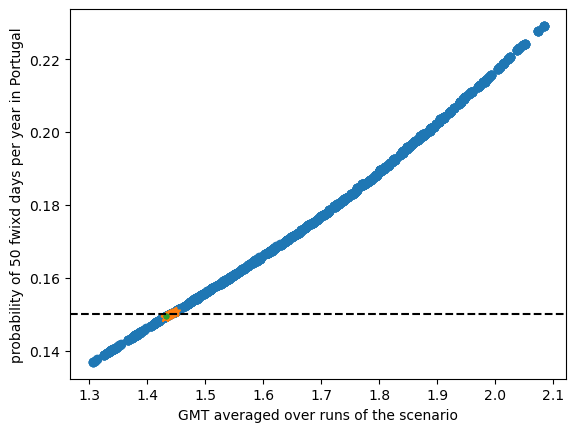

In [110]:
plt.scatter(gmt.mean('run'),p_greater.loc[:])
plt.scatter(gmt.loc[boundary_scenarios].mean('run'),p_greater.loc[boundary_scenarios],marker='*')
plt.scatter(gmt.loc[selected_scenarios].mean('run'),p_greater.loc[selected_scenarios], marker='.')
plt.xlabel('GMT averaged over runs of the scenario')
plt.ylabel('probability of 50 fwixd days per year in Portugal')
plt.axhline(p_limit, color='k', linestyle='--')

In [111]:
gmt_median = xr.open_dataset('gmt_median.nc')['gmt']

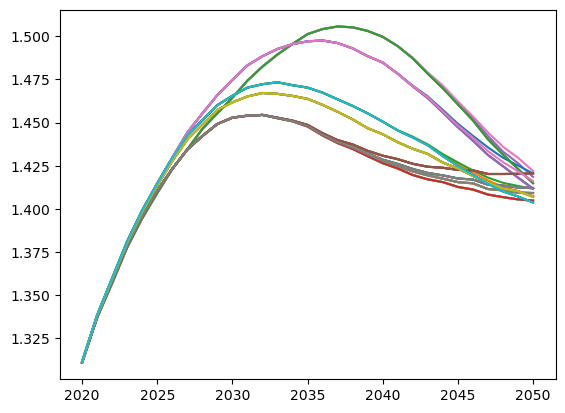

In [112]:
for scen in boundary_scenarios:
    plt.plot(gmt_median.loc[scen,2020:2050].year, gmt_median.loc[scen,2020:2050])

In [117]:
# load fair emissions
emissions = pd.read_table('../Tier2_scenarios_emissions.csv', sep=',')
co2 = emissions.loc[(emissions.Variable == 'Emissions|CO2')]
co2 = xr.DataArray(co2.iloc[:,5:].values, dims=['scen','year'], coords=dict(scen=co2.Scenario, year=np.array(co2.columns[5:], 'int')))
ch4 = emissions.loc[(emissions.Variable == 'Emissions|CH4')]
ch4 = xr.DataArray(ch4.iloc[:,5:].values, dims=['scen','year'], coords=dict(scen=ch4.Scenario, year=np.array(ch4.columns[5:], 'int')))
cum_co2 = (co2.loc[:,2020:year].rolling(year=2).sum() * 0.5 * 10).sum('year') / 1000

In [118]:
# get cumulative CO2 emissions until 2050 in the orange scenario
CO2_budget = cum_co2.loc[boundary_scenarios].values.mean()
CO2_budget

437.53523800016046